In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import torch
import torch.nn as nn
import math

# Layers
class CosineSimilarity(nn.Module):
    """
    Adapted from: https://pytorch.org/docs/master/_modules/torch/nn/modules/linear.html#Linear
    Date: 29/06/2020

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        eps: The value that is squared and added to the vectors in order to prevent a zero vector
            Default: 1e-3

    Attributes:
        weight: the learnable weights of the layer
    """
    __constants__ = ['in_features', 'out_features', 'eps']

    def __init__(self, in_features, out_features, eps=1e-3):
        super(CosineSimilarity, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.eps = eps
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    def forward(self, input):
        # w = weight, x = input
        constant = torch.pow(torch.tensor([self.eps]).cuda(), 2)
        w_x = torch.addmm(constant, input, self.weight.t())

        # Sqrt of Sum of Squares
        w_square = torch.pow(self.weight, 2)
        w_sum = torch.sum(w_square, 1)
        w_sqrt = torch.sqrt(torch.add(w_sum, constant))  # Add constant to prevent zero vector
        x_square = torch.pow(input, 2)
        x_sum = torch.sum(x_square, 1)
        x_sqrt = torch.sqrt(torch.add(x_sum, constant))

        similarity = torch.div(torch.div(w_x, w_sqrt), x_sqrt[:, None])  # Divide by w_sqrt*x_sqrt
        return similarity

    def extra_repr(self):
        return 'in_features={}, out_features={}, eps={}'.format(
            self.in_features, self.out_features, self.eps
        )

def conv_block(in_channels, out_channels): # Each conv_block reduces height and width by 2 ie. 64x64 -> 32x32
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


# Models
class BaselineNet(nn.Module):
    def __init__(self, n_way):
        super(BaselineNet, self).__init__()
        
        self.block1 = conv_block(1, 64)
        self.block2 = conv_block(64, 64)
        self.block3 = conv_block(64, 64)
        self.block4 = conv_block(64, 64)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64 * 14 * 14, n_way)  # 4 Layers of conv_block reduces size 224 to 224/(2^4) = 16

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.flatten(x)
        x = self.linear(x)
        return x


class CosineSimilarityNet(nn.Module):
    def __init__(self, n_way):
        super(CosineSimilarityNet, self).__init__()

        self.block1 = conv_block(1, 64)
        self.block2 = conv_block(64, 64)
        self.block3 = conv_block(64, 64)
        self.block4 = conv_block(64, 64)

        self.flatten = nn.Flatten()
        self.cos_sim = CosineSimilarity(64 * 14 * 14, n_way)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.flatten(x)
        x = self.cos_sim(x)
        return x


<Figure size 432x288 with 0 Axes>

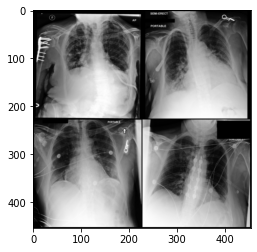

<Figure size 432x288 with 0 Axes>

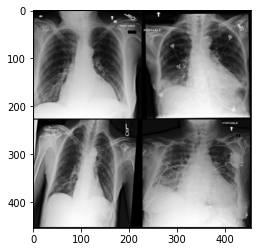

In [20]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import transforms

class MimicCxrJpg(Dataset):
    """ 
    Mimic-CXR-JPG Database
    Todo: Insert references to the database here!
    """
    
    def __init__(self, root, csv_path, mode, resize):
        
        # Check if mode contains an accepted value
        if mode not in ('base_train', 'base_validate', 'novel_train', 'novel_validate'):  
            raise Exception("Selected 'mode' is not valid")
        
        self.root = root
        csvdata = pd.read_csv(csv_path)
        self.data = csvdata[csvdata.split == mode]
        self.resize = resize
        self.transform = transforms.Compose([lambda x: Image.open(x).convert('L'),
                                             transforms.Resize((self.resize, self.resize)),
                                             transforms.ToTensor()
                                            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root, self.data.iloc[idx, 0])
        img_raw = Image
        img_tensor = self.transform(img_path)
        label = self.data.iloc[idx, 1]
        
        return (img_tensor, label)

if __name__ == '__main__':
    from matplotlib import pyplot as plt
    from torchvision.utils import make_grid
    from torch.utils.data import DataLoader
    
    mimic_dataset = MimicCxrJpg(root ='../../../../scratch/rl80/mimic-cxr-jpg-2.0.0.physionet.org/files/', 
                                csv_path='./splits.csv', mode='base_train', resize=224)
    
    dataloader = DataLoader(mimic_dataset, batch_size=4,
                            shuffle=True, num_workers=0)
    

    for i_batch, batch in enumerate(dataloader):
        plt.figure()
        image_batch = batch[0]
        plt.figure()
        grid = make_grid(image_batch, nrow=2)
        plt.imshow(grid.permute(1, 2, 0), cmap='gray')

        # Show two batches
        if i_batch == 1:
            plt.show()
            break

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, momentum=0.9)